<h1>GMM for Galaxy classification</h1>
<p>In the present notebook we introduce the Gaussian Mixture Model (GMM) analysis done in Souza et al. 2017 ( https://arxiv.org/pdf/1703.07607.pdf ) using the python scikit-learn implementation.<br>
Note that results presented in the paper were done using R and hence small differences can be found here. Note also that most figure cosmetic functions are defined separetaly in `gmm_fig_style.py` for readability.</p>

Color palette used throughout the notebook :


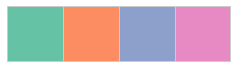

In [1]:
# importing useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
from sklearn.mixture import GaussianMixture
from gmm_fig_style import *

plt.style.use('seaborn-whitegrid')
sns.set_palette(sns.color_palette('Set2', 4))
my_cmap = mpl.cm.colors.ListedColormap(sns.color_palette('Set2', 4),
                                       name='from_list', N=4)
print('Color palette used throughout the notebook :')
sns.palplot(sns.color_palette("Set2",4))

In [2]:
# reading the catalogue
data = pd.read_csv('../Catalogue/GMM_catalogue.csv')

In [3]:
# display some information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83578 entries, 0 to 83577
Data columns (total 13 columns):
plate          83578 non-null int64
mjd            83578 non-null int64
fiber_id       83578 non-null int64
xx_BPT_WHAN    83578 non-null float64
yy_BPT         83578 non-null float64
yy_WHAN        83578 non-null float64
BPT_class      83578 non-null object
WHAN_class     83578 non-null object
GMM_class_4    83578 non-null int64
pGC1           83578 non-null float64
pGC2           83578 non-null float64
pGC3           83578 non-null float64
pGC4           83578 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 8.3+ MB


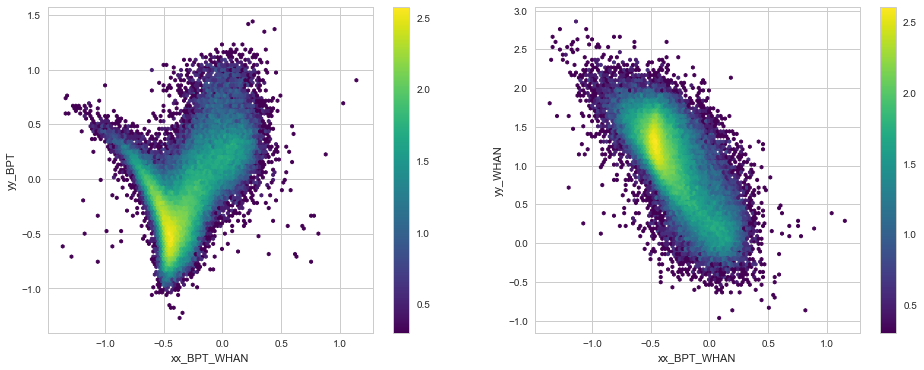

In [4]:
# A first look at the galaxy distribution in
# the BPT and WHAN diagrams
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
data.plot.hexbin(x='xx_BPT_WHAN', y='yy_BPT', mincnt=1,
                 bins='log', gridsize=101, cmap='viridis', ax=ax1)

ax2 = plt.subplot(122)
data.plot.hexbin(x='xx_BPT_WHAN', y='yy_WHAN', mincnt=1,
                 bins='log', gridsize=101, cmap='viridis', ax=ax2)



<h1>GMM clustering</h1>
<p>In our study we tried several classification method with different parameters to finally focus on the GMM technique fitting for 2, 3 and 4 clusters. I present hereafter how to perform such clustering with GMM using scikit-learn (version 0.18.1).</p>
<h3>Some Notes</h3>
<ul>
<li>The scikit GMM implementation does not always return groups in the same order. Therefore colors might not match for the different cases.</li>
<li>It is possible to directly ask GMM for the group to which each sample belongs to. Nonetheless we prefer here to return the probability per sample to belong to each group as it gives more flexibility in terms of cuts and potential future analysis.</li>
</ul>
</p>
<h3>Notes on Visualization</h3>
<p>For each case we visualize the results in three different ways :
<ul>
<li>A scatter plot with one color per group.</li>
<li>A figure representing the 68% and 95% confidence interval of the fitted gaussians.</li>
<li>A 2D kde interpolation per group (WARNING : this one can take several minutes).</li>
</ul>
</p>

<h2>2 Clusters</h2>

In [5]:
# define and train GMM
gmm2 = GaussianMixture(covariance_type='full', n_components=2)
gmm2.fit(data[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])

# return the probability of belonging to a group
proba_gmm2 = gmm2.predict_proba(data[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])
labels2 = proba_gmm2.argmax(axis=1)

# add to the initial dataframe new columns
# containing the probability to belong to a group
data['gmm2_proba1'] = proba_gmm2[:,0]
data['gmm2_proba2'] = proba_gmm2[:,1]

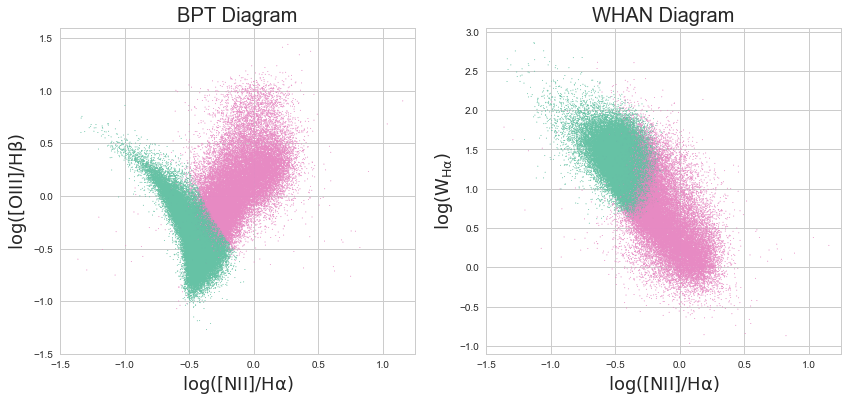

In [6]:
# visualizing the resulting classification
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(data.xx_BPT_WHAN, data.yy_BPT, c=labels2, s=0.4, cmap=my_cmap)

plt.subplot(122)
plt.scatter(data.xx_BPT_WHAN, data.yy_WHAN, c=labels2, s=0.4, cmap=my_cmap)

set_plt_style()

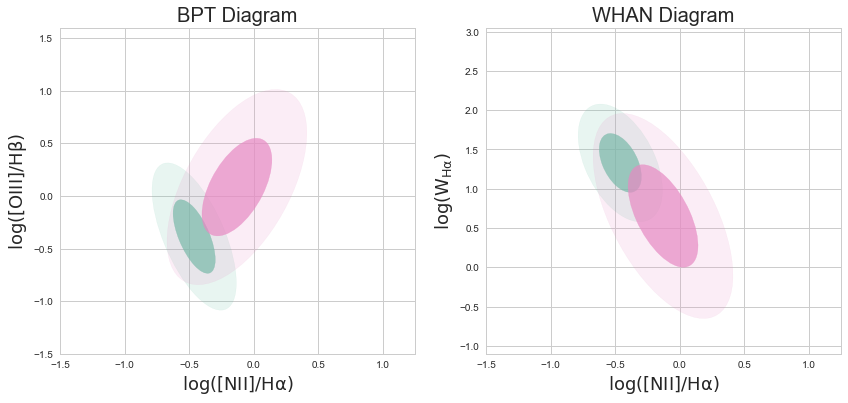

In [7]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
for i in enumerate(['C0','C3']):
    plot_BPT_ell(gmm2.covariances_[i[0]], gmm2.means_[i[0]], ax=ax1, col=i[1])

ax2 = plt.subplot(122)
for i in enumerate(['C0','C3']):
    plot_WHAN_ell(gmm2.covariances_[i[0]], gmm2.means_[i[0]], ax=ax2, col=i[1])
    
set_plt_style()

<p>Seaborn allows to visualize the density distribution using kde.
In the following plot we only focus on point with a probability to belong to a group superior to 50%.</p>

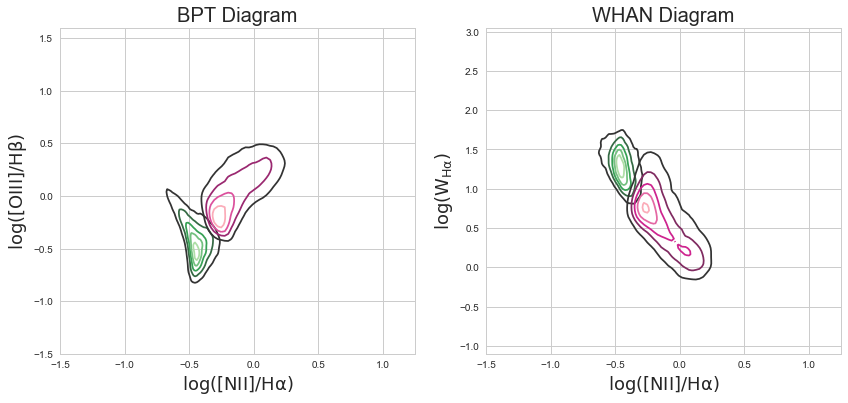

In [8]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
sns.kdeplot(data[data.gmm2_proba1>0.5].xx_BPT_WHAN, data[data.gmm2_proba1>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='Greens_d')
sns.kdeplot(data[data.gmm2_proba2>0.5].xx_BPT_WHAN, data[data.gmm2_proba2>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='RdPu_d')

ax2 = plt.subplot(122)
sns.kdeplot(data[data.gmm2_proba1>0.5].xx_BPT_WHAN, data[data.gmm2_proba1>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='Greens_d')
sns.kdeplot(data[data.gmm2_proba2>0.5].xx_BPT_WHAN, data[data.gmm2_proba2>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='RdPu_d')

set_plt_style()

<h2>3 Clusters</h2>

In [9]:
# define and train GMM
gmm3 = GaussianMixture(covariance_type='full', n_components=3)
gmm3.fit(data[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])

# return the probability of belonging to a group
proba_gmm3 = gmm3.predict_proba(data[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])
labels3 = proba_gmm3.argmax(axis=1)

# add to the initial dataframe new columns
# containing the probability to belong to a group
data['gmm3_proba1'] = proba_gmm3[:,0]
data['gmm3_proba2'] = proba_gmm3[:,1]
data['gmm3_proba3'] = proba_gmm3[:,2]

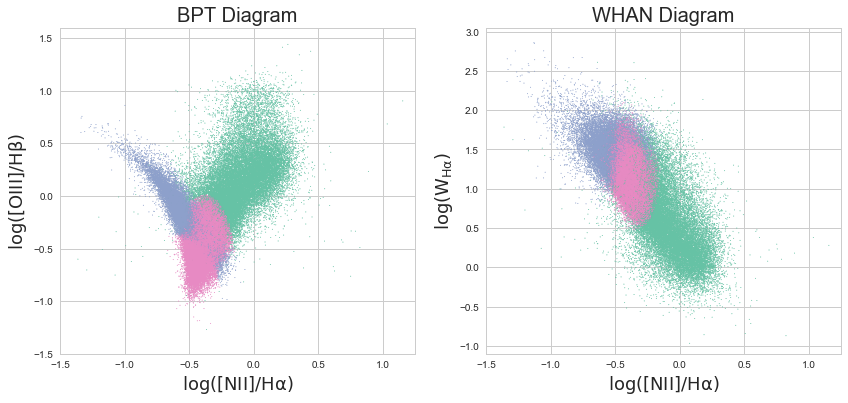

In [10]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(data.xx_BPT_WHAN, data.yy_BPT, c=labels3, s=0.4, cmap=my_cmap)

plt.subplot(122)
plt.scatter(data.xx_BPT_WHAN, data.yy_WHAN, c=labels3, s=0.4, cmap=my_cmap)

set_plt_style()

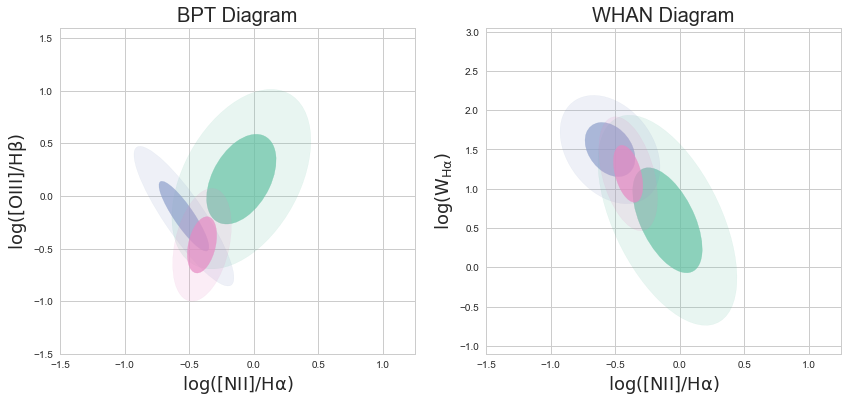

In [11]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
for i in enumerate(['C0','C2','C3']):
    plot_BPT_ell(gmm3.covariances_[i[0]], gmm3.means_[i[0]], ax=ax1, col=i[1])

ax2 = plt.subplot(122)
for i in enumerate(['C0','C2','C3']):
    plot_WHAN_ell(gmm3.covariances_[i[0]], gmm3.means_[i[0]], ax=ax2, col=i[1])

set_plt_style()

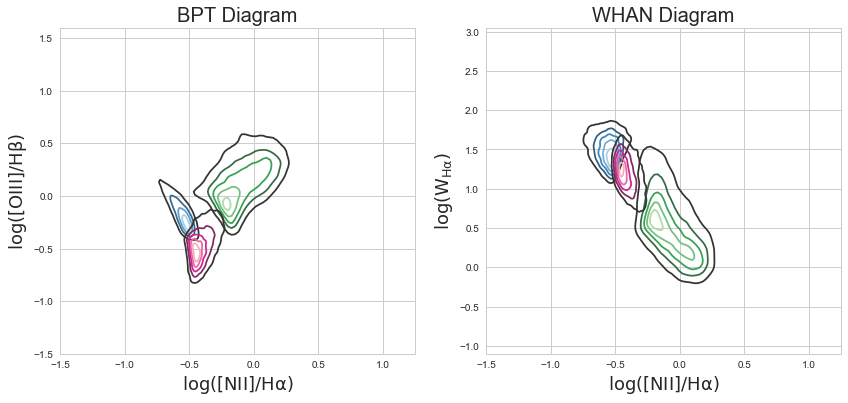

In [12]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
sns.kdeplot(data[data.gmm3_proba1>0.5].xx_BPT_WHAN, data[data.gmm3_proba1>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='Greens_d')
sns.kdeplot(data[data.gmm3_proba2>0.5].xx_BPT_WHAN, data[data.gmm3_proba2>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='Blues_d')
sns.kdeplot(data[data.gmm3_proba3>0.5].xx_BPT_WHAN, data[data.gmm3_proba3>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='RdPu_d')

ax2 = plt.subplot(122)
sns.kdeplot(data[data.gmm3_proba1>0.5].xx_BPT_WHAN, data[data.gmm3_proba1>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='Greens_d')
sns.kdeplot(data[data.gmm3_proba2>0.5].xx_BPT_WHAN, data[data.gmm3_proba2>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='Blues_d')
sns.kdeplot(data[data.gmm3_proba3>0.5].xx_BPT_WHAN, data[data.gmm3_proba3>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='RdPu_d')

set_plt_style()

<h2>4 Clusters</h2>

In [16]:
# define and train GMM
gmm4 = GaussianMixture(covariance_type='full', n_components=4)
gmm4.fit(data[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])

# return the probability of belonging to a group
proba_gmm4 = gmm4.predict_proba(data[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])
labels4 = proba_gmm4.argmax(axis=1)

# add to the initial dataframe new columns
# containing the probability to belong to a group
data['gmm4_proba1'] = proba_gmm4[:,0]
data['gmm4_proba2'] = proba_gmm4[:,1]
data['gmm4_proba3'] = proba_gmm4[:,2]
data['gmm4_proba4'] = proba_gmm4[:,3]
data['GMM4_group'] = labels4

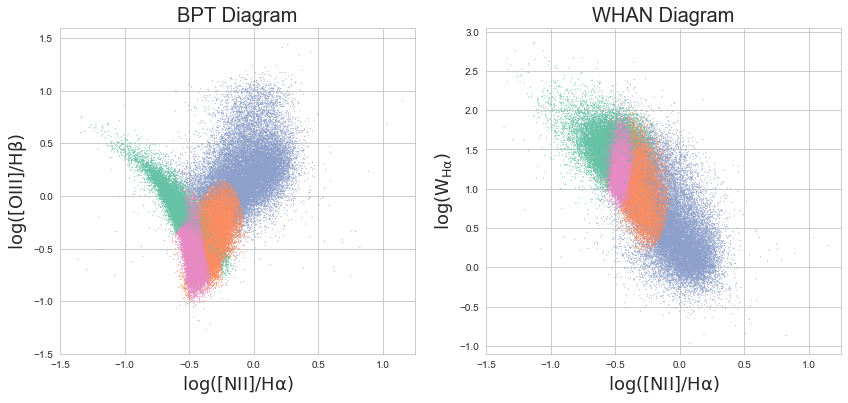

In [17]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(data.xx_BPT_WHAN, data.yy_BPT, c=labels4, s=0.4, cmap=my_cmap)

plt.subplot(122)
plt.scatter(data.xx_BPT_WHAN, data.yy_WHAN, c=labels4, s=0.4, cmap=my_cmap)

set_plt_style()

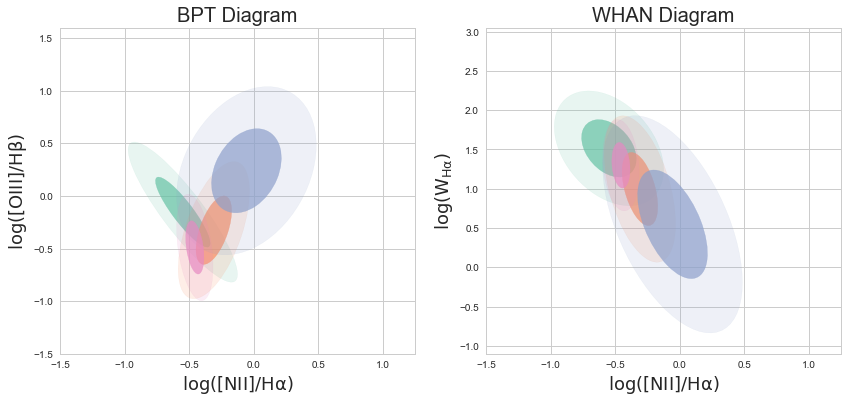

In [18]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
for i in enumerate(['C0','C1','C2','C3']):
    plot_BPT_ell(gmm4.covariances_[i[0]], gmm4.means_[i[0]], ax=ax1, col=i[1])

ax2 = plt.subplot(122)
for i in enumerate(['C0','C1','C2','C3']):
    plot_WHAN_ell(gmm4.covariances_[i[0]], gmm4.means_[i[0]], ax=ax2, col=i[1])

set_plt_style()

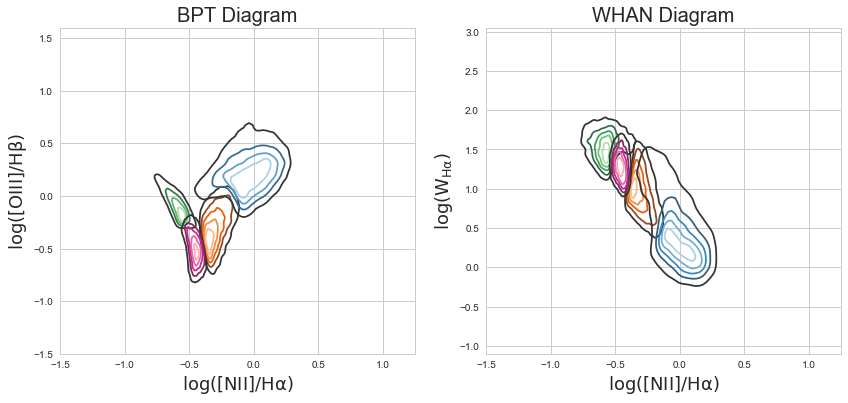

In [24]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
sns.kdeplot(data[data.gmm4_proba1>0.5].xx_BPT_WHAN, data[data.gmm4_proba1>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='Greens_d')
sns.kdeplot(data[data.gmm4_proba2>0.5].xx_BPT_WHAN, data[data.gmm4_proba2>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='Oranges_d')
sns.kdeplot(data[data.gmm4_proba3>0.5].xx_BPT_WHAN, data[data.gmm4_proba3>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='Blues_d')
sns.kdeplot(data[data.gmm4_proba4>0.5].xx_BPT_WHAN, data[data.gmm4_proba4>0.5].yy_BPT,
            bw='scott', n_levels=5, ax=ax1, cmap='RdPu_d')

ax2 = plt.subplot(122)
sns.kdeplot(data[data.gmm4_proba1>0.5].xx_BPT_WHAN, data[data.gmm4_proba1>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='Greens_d')
sns.kdeplot(data[data.gmm4_proba2>0.5].xx_BPT_WHAN, data[data.gmm4_proba2>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='Oranges_d')
sns.kdeplot(data[data.gmm4_proba3>0.5].xx_BPT_WHAN, data[data.gmm4_proba3>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='Blues_d')
sns.kdeplot(data[data.gmm4_proba4>0.5].xx_BPT_WHAN, data[data.gmm4_proba4>0.5].yy_WHAN,
            bw='scott', n_levels=5, ax=ax2, cmap='RdPu_d')

set_plt_style()

<h1>LDA Cluster Validation</h1>
<p>In this section we perform a Linear Discriminant Analysis (LDA) as an external cluster validation technique (see sec.5 of the paper for more details). We only present hereafter the case with 4 clusters.</p>

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

In [21]:
# defining some useful functions
def lda_BPT_validation(bpt_grp, gmm_grp):
    
    bpt_class = data[data.BPT_class==bpt_grp][['xx_BPT_WHAN','yy_BPT']]
    bpt_class['type'] = np.repeat(bpt_grp, repeats=len(bpt_class))
    
    gmm_gc = data[data.GMM4_group==gmm_grp][['xx_BPT_WHAN','yy_BPT']]
    gmm_gc['type'] = np.repeat('gc{}'.format(gmm_grp), repeats=len(gmm_gc)) 

    tmp = pd.concat([bpt_class,gmm_gc])
    lda.fit(tmp.drop('type', axis=1), tmp.type)
    
    bpt_lda = lda.transform(bpt_class.drop('type', axis=1))
    gc_lda = lda.transform(gmm_gc.drop('type', axis=1))

    return bpt_lda.ravel(), gc_lda.ravel()

def lda_WHAN_validation(whan_grp, gmm_grp):
    
    whan_class = data[data.WHAN_class==whan_grp][['xx_BPT_WHAN','yy_WHAN']]
    whan_class['type'] = np.repeat(whan_grp, repeats=len(whan_class))
    
    gmm_gc = data[data.GMM4_group==gmm_grp][['xx_BPT_WHAN','yy_WHAN']]
    gmm_gc['type'] = np.repeat('gc{}'.format(gmm_grp), repeats=len(gmm_gc)) 

    tmp = pd.concat([whan_class,gmm_gc])
    lda.fit(tmp.drop('type', axis=1), tmp.type)
    
    whan_lda = lda.transform(whan_class.drop('type', axis=1))
    gc_lda = lda.transform(gmm_gc.drop('type', axis=1))

    return whan_lda.ravel(), gc_lda.ravel()

<h2>Comparison with the BPT classification</h2>

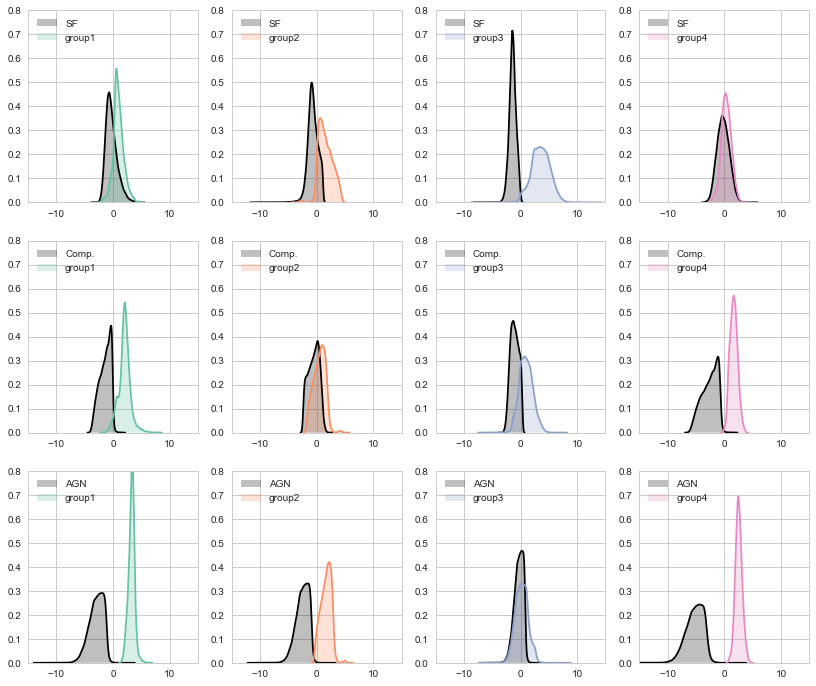

In [22]:
plt.figure(figsize=(14,12))

i = 0
for bpt,gc in itertools.product(['SF','Composite','AGN'],enumerate(['C0','C1','C2','C3'])):
    i += 1
    bpt_lda, gc_lda = lda_BPT_validation(bpt,gc[0])
    plt.subplot(3,4,i)
    sns.kdeplot(bpt_lda, shade=True, color='k')
    sns.kdeplot(gc_lda, shade=True, color=gc[1])
    
lda_bpt_plt_style()

<h2>Comparison with the WHAN classification</h2>

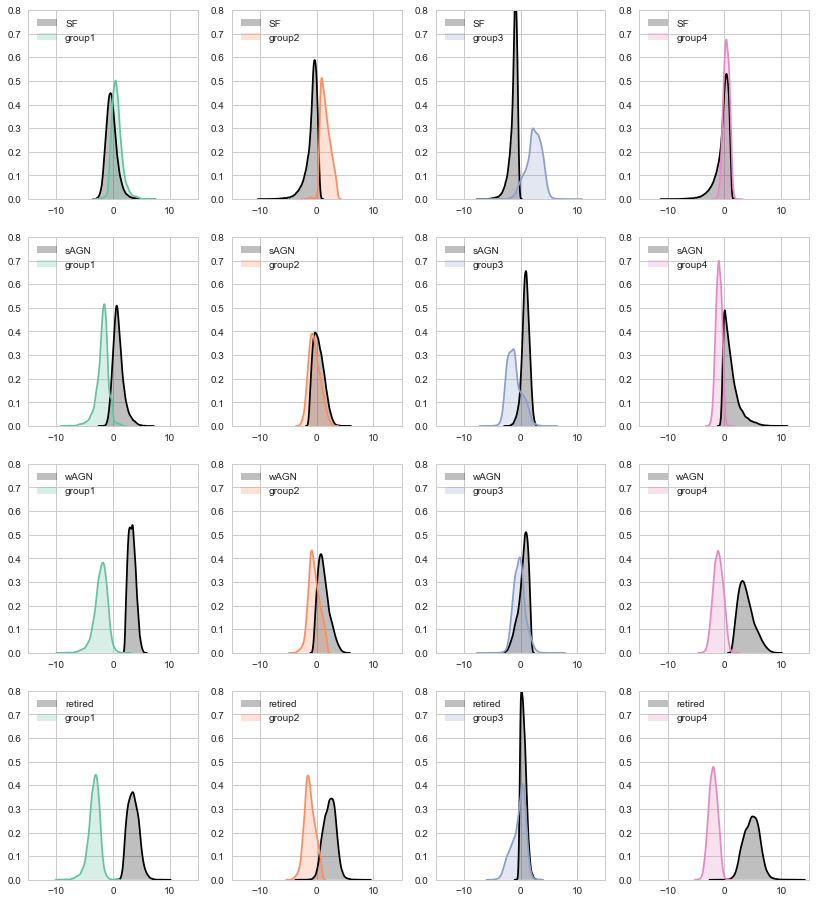

In [23]:
plt.figure(figsize=(14,16))

i = 0
for whan,gc in itertools.product(['SF','sAGN','wAGN','retired'],enumerate(['C0','C1','C2','C3'])):
    i += 1
    whan_lda, gc_lda = lda_WHAN_validation(whan,gc[0])
    plt.subplot(4,4,i)
    sns.kdeplot(whan_lda, shade=True, color='k')
    sns.kdeplot(gc_lda, shade=True, color=gc[1])
    
lda_whan_plt_style()